In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import cm

import models.models_mae_vit
import models.models_mae_cnn
import cv2

SyntaxError: invalid syntax (3135733843.py, line 13)

In [32]:
img_list_val = list()
img_list_val_labels = list()
data_dir = 'data/test_official'
with open('data/test_official.txt', "r", encoding='utf-8') as fileDescriptor:
    line = True
    while line:
        line = fileDescriptor.readline()
        if line:
            lineItems = line.split()
            imagePath = os.path.join(data_dir, lineItems[0])
            imageLabel = lineItems[1:1 + 1]
            imageLabel = [int(i) for i in imageLabel]
            img_list_val.append(imagePath)
            img_list_val_labels.append(imageLabel)
img_list_val

['data/test_official\\12876450_2.jpg',
 'data/test_official\\12876450_3.jpg',
 'data/test_official\\12876450_4.jpg',
 'data/test_official\\12876450_5.jpg',
 'data/test_official\\12886436_1.jpg',
 'data/test_official\\12886436_2.jpg',
 'data/test_official\\12886436_4.jpg',
 'data/test_official\\12886436_5.jpg',
 'data/test_official\\128871719_1.jpg',
 'data/test_official\\128871719_2.jpg',
 'data/test_official\\128871719_3.jpg',
 'data/test_official\\128871719_4.jpg',
 'data/test_official\\128871719_6.jpg',
 'data/test_official\\12897401_1.jpg',
 'data/test_official\\12897401_2.jpg',
 'data/test_official\\12897401_3.jpg',
 'data/test_official\\12897401_4.jpg',
 'data/test_official\\142865029_1.jpg',
 'data/test_official\\142865029_2.jpg',
 'data/test_official\\142865029_3.jpg',
 'data/test_official\\14286502_20211208_1.jpg',
 'data/test_official\\14286502_20211208_2.jpg',
 'data/test_official\\14297819_1.jpg',
 'data/test_official\\14297819_2.jpg',
 'data/test_official\\14297819_3.jpg',

In [33]:
def load_img_gray(path, size=224, mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])):
    img = Image.open(path).convert('RGB')
    img = img.resize((size, size))
    img = np.array(img) / 255.
    assert img.shape == (size, size, 3)
    # normalize by ImageNet mean and std
    img = img - mean
    img = img / std
    return img

In [34]:
shoulderxray_mean = np.array([0.5056, 0.5056, 0.5056])
shoulderxray_std = np.array([0.252, 0.252, 0.252])

In [35]:
def prepare_model_cnn(chkpt_dir, model_arch='Unet', encoder_model='densenet121'):
    # build model
    model = models_mae_cnn.MaskedAutoencoderCNN(img_size=224, patch_size=16, model_arch='Unet', encoder_name=encoder_model)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

In [36]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [37]:
def show_image(image, title='', mean=shoulderxray_mean, std=shoulderxray_std):
    # image is [H, W, 3]
    assert image.shape[2] == 3

    plt.imshow(torch.clip((image * std + mean) * 255, 0, 255).int()[:,:,0], cmap='gray')
    plt.title(title, fontsize=16)
    plt.axis('off')
#     print(title,'min:', image.min().item(),'max:', image.max().item())
#     print(title,'mean:', image.mean().item(),'std:',  image.std().item())
    return torch.clip((image * std + mean) * 255, 0, 255).numpy().astype(np.uint8)[:,:,0]


In [38]:
def pick_best_image_over_runs(img, model, mask_ratio=0.75, run=1):
    # run MAE
    lowest_loss = 100
    for seed in range(run):
        x = torch.tensor(img)

        # make it a batch-like
        x = x.unsqueeze(dim=0)
        x = torch.einsum('nhwc->nchw', x)
        torch.manual_seed(seed)
        loss, y, mask = model(x.float(), mask_ratio=mask_ratio)
        if loss.detach().numpy().item() < lowest_loss:
            lowest_loss = loss.detach().numpy().item()
            best_seed = seed
        print(loss.detach().numpy())
    
    x = torch.tensor(img)
    torch.manual_seed(best_seed)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio)
    print(loss.detach().numpy())
    print(x.shape)
    mask = mask.unsqueeze(-1).repeat(1, 1, 16**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    print(mask.shape)
    print(y.shape)
#     y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
#     x_masked = self.unpatchify(x * (1 - mask.unsqueeze(-1)))

#     mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
#     mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
#     mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 5, 1)
    img_original = show_image(x[0], "original")

    plt.subplot(1, 5, 2)
    img_masked = show_image(im_masked[0], "masked")

    plt.subplot(1, 5, 3)
    img_reconstruction = show_image(y[0], "reconstruction")
    plt.subplot(1, 5, 4)
    img_paste = show_image(im_paste[0], "reconstruction + visible")
    plt.subplot(1, 5, 5)
    show_image(torch.abs(x[0] - im_paste[0]), "raw - (reconstruction + visible)")
    plt.show()
    return [img_original, img_masked, img_paste]

<All keys matched successfully>
[1]
0.11836685
0.11836685
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


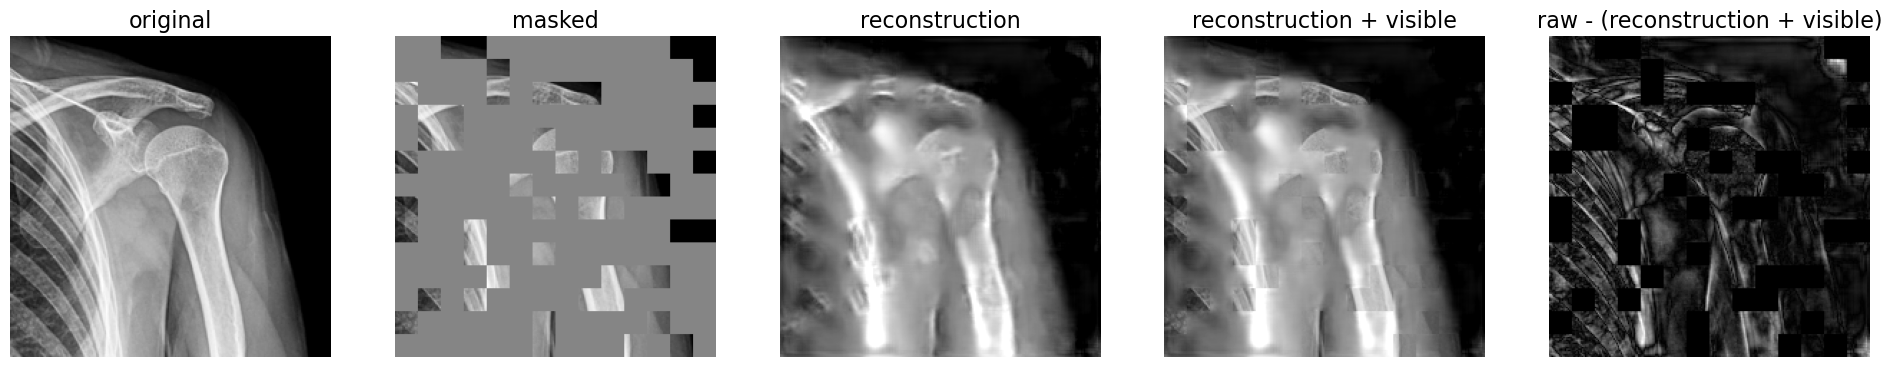

(224, 224)
[1]
0.14630571
0.14630571
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


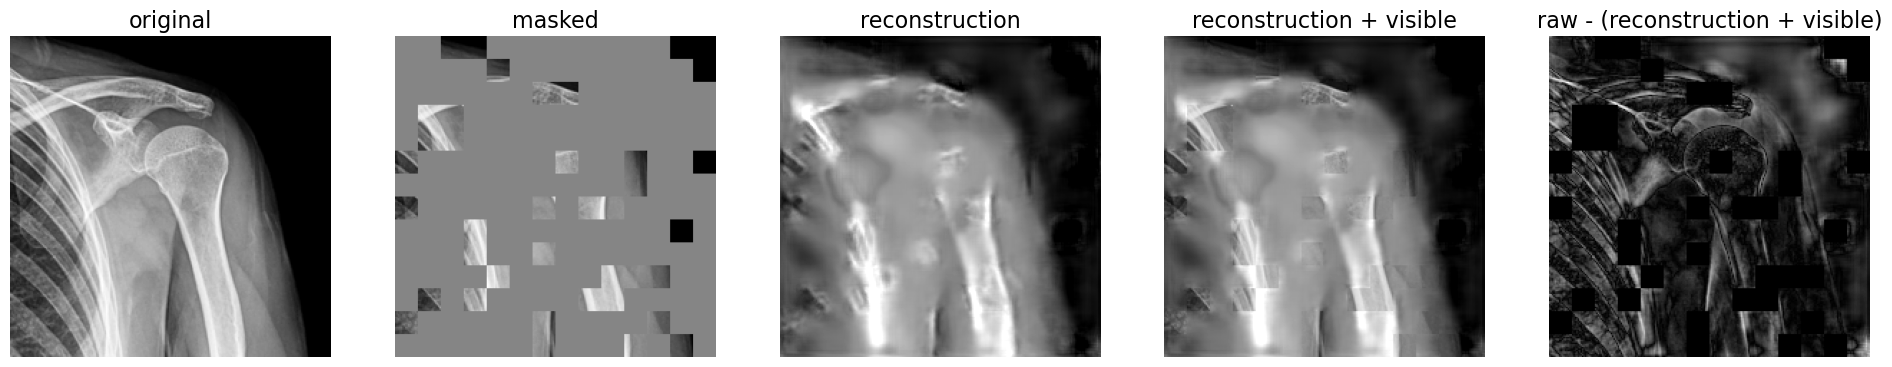

(224, 224)
[1]
0.2546006
0.2546006
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


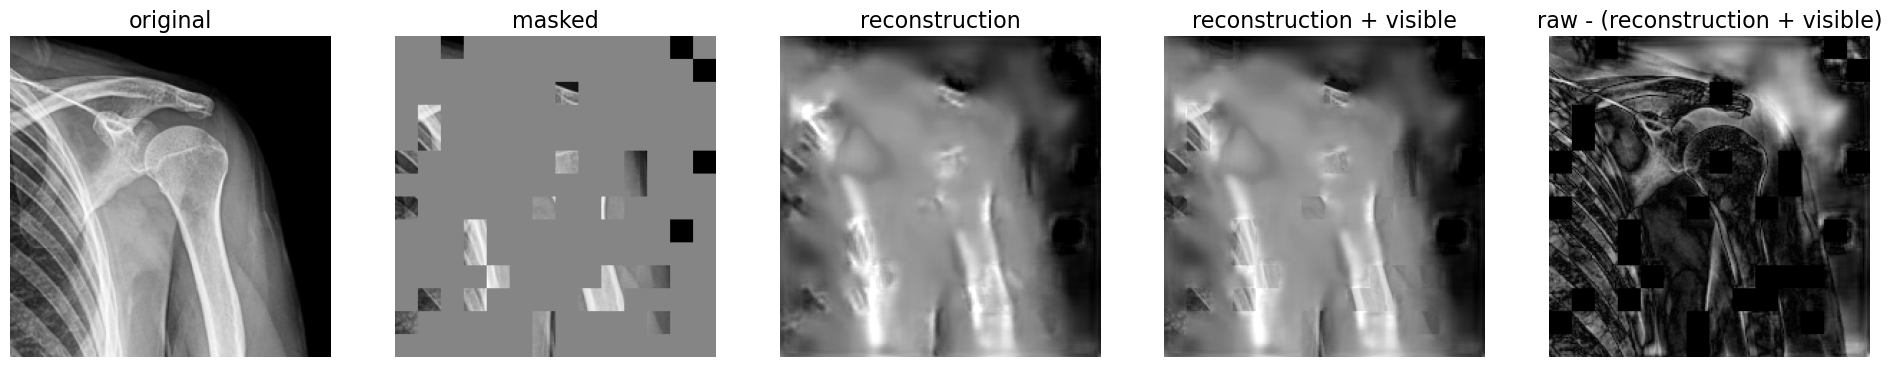

(224, 224)
[1]
0.5533733
0.5533733
torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


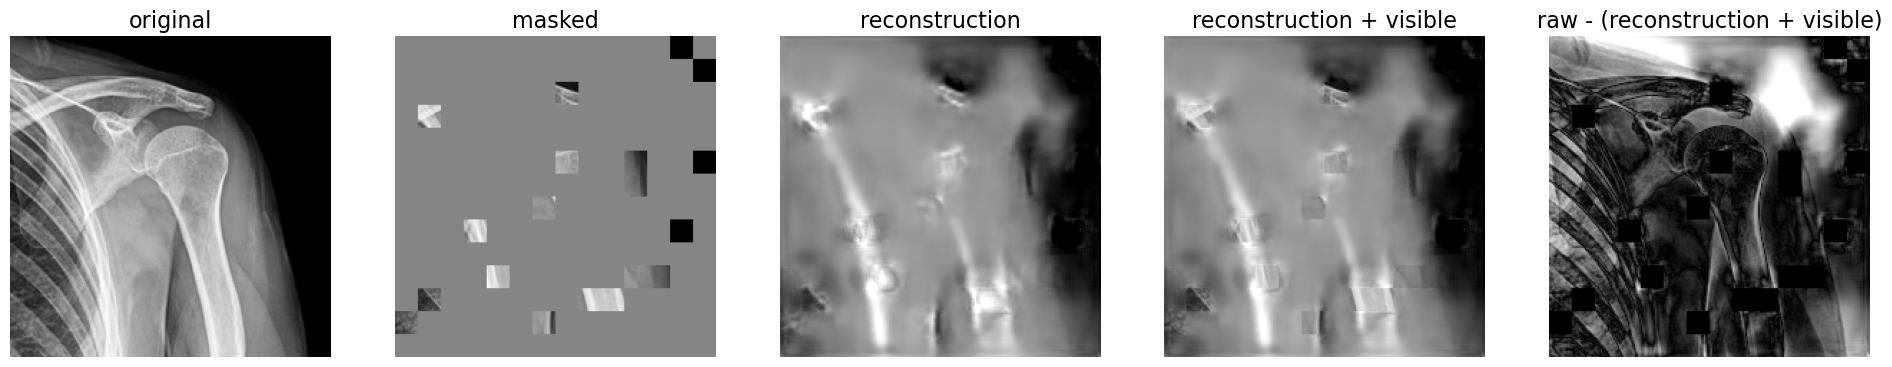

(224, 224)


In [39]:
# img_from_val_path = 'data/nih_chestxray/00000087_000.png'
chkpt_dir = './models/densenet121_RandomCrop_1.4K_mae_800epc.pth'
model_mae = prepare_model_cnn(chkpt_dir, model_arch='Unet', encoder_model='densenet121')
i = 3
for mask_ratio_percentage in [75, 80, 85, 90]:
    img_from_val_path = img_list_val[i]
    print(img_list_val_labels[i])
    img_from_val = load_img_gray(img_from_val_path, size=224, mean=shoulderxray_mean, std=shoulderxray_std)
    img_original, img_masked, img_paste = pick_best_image_over_runs(img_from_val, model_mae, mask_ratio=0.01 * mask_ratio_percentage, run=1)
    print(img_masked.shape)
    plt.imsave(f'figures/RandomCrop/densenet121_opriginal{mask_ratio_percentage}_img{i}.png', img_original, cmap=cm.gray)
    plt.imsave(f'figures/RandomCrop/densenet121_masked_input_mask{mask_ratio_percentage}_img{i}.png', img_masked, cmap=cm.gray)
    plt.imsave(f'figures/RandomCrop/densenet121_reconstruction_mask{mask_ratio_percentage}_img{i}.png', img_paste, cmap=cm.gray)